In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURACIÓN ESTÉTICA (Mantenida según tu estilo) ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 8

def generate_final_thesis_plots():
    output_dir = "Graficos_Finales_TFM"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 1. CARGAR DATOS EXHAUSTIVOS
    df_stats = pd.read_csv("/kaggle/input/phase2/PHASE_2_1_EXHAUSTIVE_STATS.csv")
    df_trans = pd.read_csv("/kaggle/input/phase2/PHASE_2_1_EXHAUSTIVE_TRANSITORY.csv")

    # --- IDENTIFICAR LABELS Y COLORES ---
    # Separamos Proporcional de Fermi para asignar colores Viridis solo a Fermi
    all_labels = df_stats['Label'].unique()
    fermi_labels = sorted([l for l in all_labels if "Fermi" in l])
    # Generamos la paleta Viridis exactamente como en tu código original
    fermi_colors = sns.color_palette("viridis", len(fermi_labels))
    color_map = {label: fermi_colors[i] for i, label in enumerate(fermi_labels)}

    # --- GRÁFICO A: ESTADOS ESTACIONARIOS (C_mean vs b) ---
    plt.figure(figsize=(11, 7))
    
    # Graficar Proporcional (Referencia en Negro)
    prop_data = df_stats[df_stats['Label'] == 'Proportional'].sort_values('b')
    if not prop_data.empty:
        plt.plot(prop_data['b'], prop_data['rho_mean'], 'k--', 
                 label='Proporcional (Ref)', marker='x', zorder=10)

    # Graficar Fermi (Colores Viridis)
    for label in fermi_labels:
        data = df_stats[df_stats['Label'] == label].sort_values('b')
        plt.plot(data['b'], data['rho_mean'], marker='o', 
                 label=label, color=color_map[label], alpha=0.8)

    plt.title("Estudio Exhaustivo: Niveles de Cooperación (BA $Z=4$)", fontweight='bold')
    plt.xlabel("Tentación $b$")
    plt.ylabel("Cooperación Media $\\langle \\rho \\rangle$")
    plt.ylim(-0.02, 1.02)
    plt.legend(title="Regla de Actualización", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/Final_Stats_Comparison.png", dpi=300)
    plt.close()

    # --- GRÁFICO B: SERIES TEMPORALES (Fase Transitoria) ---
    # Seleccionamos b crítico (ej: 1.85) para mostrar la caída
    b_critico = 1.85
    plt.figure(figsize=(11, 7))

    # Proporcional en b_critico
    p_trans = df_trans[(df_trans['Label'] == 'Proportional') & (df_trans['b'] == b_critico)]
    if not p_trans.empty:
        plt.plot(p_trans['step'], p_trans['rho_t'], 'k--', label='Proporcional')

    # Fermi en b_critico
    for label in fermi_labels:
        f_trans = df_trans[(df_trans['Label'] == label) & (df_trans['b'] == b_critico)]
        if not f_trans.empty:
            plt.plot(f_trans['step'], f_trans['rho_t'], color=color_map[label], label=label)

    plt.title(f"Dinámica Temporal de la Cooperación ($b={b_critico}$)", fontweight='bold')
    plt.xlabel("Pasos de tiempo (Steps)")
    plt.ylabel("Fracción de Cooperadores $\\rho(t)$")
    plt.ylim(-0.02, 1.02)
    plt.legend(title="Evolución temporal", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/Final_Transitory_b185.png", dpi=300)
    plt.close()

    print(f"Gráficos generados con éxito en la carpeta '{output_dir}'")

# Ejecutar
generate_final_thesis_plots()

Gráficos generados con éxito en la carpeta 'Graficos_Finales_TFM'


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURACIÓN ESTÉTICA (Estilo TFM) ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 8

def generar_graficos_convergencia_v6():
    output_dir = "Graficos_Finales_TFM"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # El archivo que el usuario especificó
    file_path = "/kaggle/input/phase2/P2_1_FERMI_vs_PROP_convergence_steps_corrMAX1.csv"
    
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"Error al leer {file_path}: {e}")
        return

    # Verificar nombres de columnas
    print("Columnas encontradas:", df.columns.tolist())
    
    # Asegurarnos de que los nombres coincidan (manejo de mayúsculas/minúsculas)
    # Buscamos las columnas necesarias
    col_topo = 'Topo' if 'Topo' in df.columns else 'topo'
    col_z = 'Z' if 'Z' in df.columns else 'z'
    col_b = 'b'
    col_update = 'Update' if 'Update' in df.columns else 'regle'
    col_k = 'K' if 'K' in df.columns else 'k'
    col_t = 'Tstop_mean' if 'Tstop_mean' in df.columns else 't'
    col_std = 'Tstop_std' if 'Tstop_std' in df.columns else None

    REPS = 100
    escenarios = [("BA", 4), ("ER", 16)]

    for topo_val, z_val in escenarios:
        sub = df[(df[col_topo] == topo_val) & (df[col_z] == z_val)].copy()
        if sub.empty:
            print(f"No hay datos para {topo_val} Z={z_val}")
            continue
            
        plt.figure(figsize=(11, 7))

        # 1. REGLA PROPORCIONAL (Negro discontinuo)
        prop = sub[sub[col_update].str.lower().isin(['proportional', 'prop'])].sort_values(col_b)
        if not prop.empty:
            plt.plot(prop[col_b], prop[col_t], 'k--', lw=3, 
                     label='Proporcional (Ref)', marker='x', zorder=10)
            if col_std:
                se_prop = prop[col_std] / np.sqrt(REPS)
                plt.fill_between(prop[col_b], prop[col_t] - se_prop, prop[col_t] + se_prop, 
                                 color='k', alpha=0.1, zorder=9)

        # 2. REGLA FERMI (Paleta Viridis)
        fermi_sub = sub[sub[col_update].str.lower() == 'fermi']
        ks = sorted(fermi_sub[col_k].dropna().unique())
        colors = sns.color_palette("viridis", len(ks))

        for i, k_val in enumerate(ks):
            data = fermi_sub[fermi_sub[col_k] == k_val].sort_values(col_b)
            plt.plot(data[col_b], data[col_t], marker='o', 
                     label=f'Fermi $K={k_val}$', color=colors[i], alpha=0.8)
            if col_std:
                se_fermi = data[col_std] / np.sqrt(REPS)
                plt.fill_between(data[col_b], data[col_t] - se_fermi, data[col_t] + se_fermi, 
                                 color=colors[i], alpha=0.15)

        # Configuración de ejes
        plt.yscale('log')
        plt.title(f"Tiempo de Convergencia ($T_{{stop}}$): {topo_val} $Z={z_val}$", fontweight='bold')
        plt.xlabel("Tentación $b$")
        plt.ylabel("Pasos de tiempo (Escala Log)")
        plt.legend(title="Regla de Actualización", bbox_to_anchor=(1.02, 1), loc='upper left')
        
        plt.tight_layout()
        filename = f"{output_dir}/Final_Convergence_Time_{topo_val}_Z{z_val}.png"
        plt.savefig(filename, dpi=300)
        plt.close()
        print(f"Gráfico guardado en: {filename}")

generar_graficos_convergencia_v6()

Columnas encontradas: ['Topo', 'Z', 'b', 'Update', 'K', 'C_mean', 'Tstop_mean', 'Tstop_std', 'Stop_absorb_frac', 'Stop_std_frac', 'Stop_max_frac']
Gráfico guardado en: Graficos_Finales_TFM/Final_Convergence_Time_BA_Z4.png
Gráfico guardado en: Graficos_Finales_TFM/Final_Convergence_Time_ER_Z16.png


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURACIÓN ESTÉTICA ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['figure.figsize'] = (10, 6)
colors = sns.color_palette("viridis", 3)

def generar_grafico_regimenes_tfm(file_path):
    output_dir = "Graficos_Finales_TFM"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    df = pd.read_csv(file_path)

    # Enfoque en Fermi con K = 0.1
    k_focus = 0.1
    data = df[
        (df['Update'] == 'fermi') &
        (df['K'] == k_focus)
    ].sort_values('b')

    if data.empty:
        print("No se encontraron datos para el criterio seleccionado.")
        return

    plt.figure(figsize=(11, 7))

    # Regímenes finales
    plt.stackplot(
        data['b'],
        data['Stop_absorb_frac'],
        data['Stop_std_frac'],
        data['Stop_max_frac'],
        labels=[
            'Fijación (Estado Absorbente)',
            'Estado Estacionario',
            'Tiempo Límite Alcanzado'
        ],
        colors=colors,
        alpha=0.8
    )

    # Estética
    plt.title(
        f"Regímenes de Finalización (Fermi $K={k_focus}$, BA $Z=4$)",
        fontweight='bold'
    )
    plt.xlabel("Tentación $b$")
    plt.ylabel("Fracción de las Simulaciones")
    plt.ylim(0, 1)
    plt.xlim(data['b'].min(), data['b'].max())
    plt.legend(loc='lower left', frameon=True, framealpha=0.9)

    plt.tight_layout()
    filename = f"{output_dir}/Final_Regimenes_BA4_Fermi_K{str(k_focus).replace('.', '')}.png"
    plt.savefig(filename, dpi=300)
    plt.close()

    print(f"Gráfico de regímenes guardado en: {filename}")

# Ejecutar
generar_grafico_regimenes_tfm(
    "/kaggle/input/phase2/P2_1_BA4_PUSHED_VERIFICATION.csv"
)


Gráfico de regímenes guardado en: Graficos_Finales_TFM/Final_Regimenes_BA4_Fermi_K01.png


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURACIÓN ESTÉTICA (Estilo Publicación Científica / TFM) ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 8

def generar_graficos_tfm_final():
    """
    Genera gráficos de transición de fase comparando Amnesia vs Memoria.
    Asegura colores distintos y fijos para cada curva.
    """
    output_dir = "Resultados_TFM"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Ruta del archivo (ajustar si es necesario)
    file_path = "/kaggle/input/phase2/P212_2_MEMORY_vs_AMNESIC_corrMAX_cost0_prop_OPT.csv"
    
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {file_path}")
        return

    # Escenarios disponibles (BA, ER, etc.)
    escenarios = df['Topo'].unique()
    
    # --- PALETA DE COLORES FIJA ---
    # Usamos nombres exactos del CSV para evitar errores
    colores_dict = {
        "amnesic": "#31688e",  # Azul Oscuro / Gris (Referencia estable)
        "memory": "#35b779"    # Rojo (Resaltar el efecto memoria)
    }

    for topo in escenarios:
        plt.figure(figsize=(10, 6))
        
        # Filtramos datos por topología
        sub = df[df['Topo'] == topo].copy()
        
        # Iteramos sobre los modos de vigilancia
        # 'sorted' asegura un orden consistente en la leyenda
        for mode in sorted(sub['VigilanceMode'].unique()):
            data = sub[sub['VigilanceMode'] == mode].sort_values('b')
            
            # Dibujamos la curva usando el color del diccionario
            plt.plot(
                data['b'], 
                data['C_mean'], 
                marker='o', 
                label=f'Modo: {mode.capitalize()}', 
                color=colores_dict.get(mode, "black") # Negro si no encuentra el modo
            )

        # --- CONFIGURACIÓN DE EJES Y TÍTULOS EN ESPAÑOL ---
        plt.title(f"Transicion de Fase: {topo} Z=16 - Impacto global", fontweight='bold')
        plt.xlabel("Factor de tentación $b$")
        plt.ylabel(r"Densidad de cooperación $\rho$ ($C_{mean}$)")
        
        # Ajustes de límites para mayor claridad
        plt.ylim(-0.05, 1.05)
        plt.legend(title="Estrategia de Vigilancia", frameon=True)
        
        plt.tight_layout()
        
        # Guardado del archivo
        filename = f"{output_dir}/Transicion_Fase_{topo}_Memoria.png"
        plt.savefig(filename, dpi=300)
        plt.close()
        print(f"Éxito: Gráfico generado para {topo} en '{filename}'")

# Ejecutar la función
if __name__ == "__main__":
    generar_graficos_tfm_final()

Éxito: Gráfico generado para BA en 'Resultados_TFM/Transicion_Fase_BA_Memoria.png'
Éxito: Gráfico generado para ER en 'Resultados_TFM/Transicion_Fase_ER_Memoria.png'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURACIÓN ESTÉTICA ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 8

# Paleta de colores consistente
colores_dict = {
    "amnesic": "#31688e",  # Azul oscuro
    "memory": "#35b779"    # Verde esmeralda
}

def setup_dir(name):
    if not os.path.exists(name):
        os.makedirs(name)

output_dir = "Graficos_Impacto_Vigilancia"
setup_dir(output_dir)

# =========================================================
# 2. DINÁMICA TEMPORAL (Efecto de Inercia)
# =========================================================
def plot_dinamica_temporal():
    file = "FORCED_START_TRANSITORY.csv"
    if not os.path.exists(file): return
    
    df = pd.read_csv(file)
    # Valores críticos sugeridos
    configs = [("BA", 1.8), ("ER", 1.4)]
    
    for topo, b_val in configs:
        plt.figure(figsize=(10, 6))
        sub = df[(df['Topo'] == topo) & (df['b'] == b_val)]
        
        for mode in sub['Mode'].unique():
            data = sub[sub['Mode'] == mode].sort_values('step')
            plt.plot(data['step'], data['rho_t'], 
                     label=f'Modo: {mode.capitalize()}', 
                     color=colores_dict.get(mode.lower()))

        plt.title(f"Efecto de Inercia ({topo}): Evolución de la Cooperación ($b={b_val}$)")
        plt.xlabel("Pasos de tiempo (Steps)")
        plt.ylabel(r"Densidad de cooperación $\rho(t)$")
        plt.legend(title="Tipo de Vigilancia")
        plt.tight_layout()
        plt.savefig(f"{output_dir}/Dinamica_Temporal_{topo}.png", dpi=300)
        plt.close()

# =========================================================
# 3. CORRELACIÓN DE HUBS (Rol de los Líderes)
# =========================================================
def plot_correlacion_hubs():
    file = "HUB_CORRELATION_ANALYSIS_precision005.csv"
    if not os.path.exists(file): return
    
    df = pd.read_csv(file)
    topos = df['Topo'].unique()
    
    for topo in topos:
        plt.figure(figsize=(11, 7))
        sub = df[df['Topo'] == topo]
        
        for mode in sub['Mode'].unique():
            m_data = sub[sub['Mode'] == mode].groupby('b').mean().reset_index()
            color = colores_dict.get(mode.lower())
            
            # Global
            plt.plot(m_data['b'], m_data['rho_global'], marker='o', linestyle='--',
                     color=color, label=f'Global ({mode.capitalize()})', alpha=0.6)
            # Hubs
            plt.plot(m_data['b'], m_data['rho_hubs'], marker='s', linestyle='-',
                     color=color, label=f'Hubs ({mode.capitalize()})')

        plt.title(f"Lucha de los Hubs vs Media Global: {topo}")
        plt.xlabel("Factor de tentación $b$")
        plt.ylabel(r"Densidad de cooperación $\rho$")
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(f"{output_dir}/Correlacion_Hubs_{topo}.png", dpi=300)
        plt.close()

# =========================================================
# 4. DENSIDAD DE VIGILANCIA (Costo de la Estrategia)
# =========================================================
def plot_densidad_vigilancia():
    file = "P2_2_BA16_VÉRIFICATION.csv"
    if not os.path.exists(file): return
    
    df = pd.read_csv(file)
    topos = df['Topo'].unique()
    
    for topo in topos:
        plt.figure(figsize=(10, 6))
        sub = df[df['Topo'] == topo]
        
        for mode in sub['VigilanceMode'].unique():
            data = sub[sub['VigilanceMode'] == mode].sort_values('b')
            plt.plot(data['b'], data['V_mean'], marker='^',
                     label=f'Vigilancia ({mode.capitalize()})',
                     color=colores_dict.get(mode.lower()))

        plt.title(f"Sostenibilidad de la Vigilancia: {topo}")
        plt.xlabel("Factor de tentación $b$")
        plt.ylabel("Densidad de Vigilantes ($V_{mean}$)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"{output_dir}/Densidad_Vigilancia_{topo}.png", dpi=300)
        plt.close()

# =========================================================
# 5. HEATMAP DE SENSIBILIDAD (Theta vs b)
# =========================================================
def plot_heatmaps_sensibilidad():
    file = "P2_2_BA16_VÉRIFICATION.csv"
    if not os.path.exists(file): return
    
    df = pd.read_csv(file)
    topos = df['Topo'].unique()
    
    for topo in topos:
        sub_topo = df[df['Topo'] == topo]
        fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
        
        modes = sorted(sub_topo['VigilanceMode'].unique())
        
        for i, mode in enumerate(modes):
            data = sub_topo[sub_topo['VigilanceMode'] == mode]
            # Pivotar datos para el heatmap
            pivot = data.pivot_table(index='Theta', columns='b', values='C_mean')
            
            sns.heatmap(pivot, ax=axes[i], cmap="viridis", annot=False, vmin=0, vmax=1)
            axes[i].set_title(f"Modo: {mode.capitalize()}")
            axes[i].invert_yaxis()
            axes[i].set_xlabel("Tantación $b$")
            axes[i].set_ylabel("Umbral $\theta$")

        plt.suptitle(f"Zonas de Supervivencia de la Cooperación: {topo}", fontweight='bold', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(f"{output_dir}/Heatmap_Sensibilidad_{topo}.png", dpi=300)
        plt.close()

# Ejecutar generadores
print("Generando gráficos...")
plot_dinamica_temporal()
plot_correlacion_hubs()
plot_densidad_vigilancia()
plot_heatmaps_sensibilidad()
print(f"Hecho. Todos los gráficos están en la carpeta: {output_dir}")

Generando gráficos...
Hecho. Todos los gráficos están en la carpeta: Graficos_Impacto_Vigilancia


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIG ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.3)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.5

def plot_means_vs_b(
    stats_csv_path,
    output_dir="Resultados_Stats_vs_b",
    mode_col="Mode",
    topo_col="Topo",
    b_col="b"
):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    df = pd.read_csv(stats_csv_path)

    # --- Robust column matching (au cas où) ---
    colmap = {c.lower(): c for c in df.columns}

    def pick_col(candidates):
        for cand in candidates:
            if cand.lower() in colmap:
                return colmap[cand.lower()]
        return None

    b_col = pick_col([b_col, "B"])
    topo_col = pick_col([topo_col, "topo", "Topology"])
    mode_col = pick_col([mode_col, "mode", "Modo"])

    rho_col = pick_col(["c_mean", "Rho_mean", "rho", "rho_final_mean"])
    # vigilance moyenne : accepte plusieurs noms possibles
    vig_col = pick_col(["vig_mean", "v_mean", "rho_vig_mean", "rho_vig", "vig"])

    if b_col is None or mode_col is None:
        raise ValueError(f"Colonnes indispensables manquantes. Colonnes trouvées: {list(df.columns)}")

    if rho_col is None:
        raise ValueError("Impossible de trouver une colonne de type rho_mean (ex: 'rho_mean').")

    if vig_col is None:
        print("⚠️ Aucune colonne de vigilance moyenne trouvée (vig_mean / v_mean / rho_vig_mean). "
              "Je ne tracerai que rho_mean.")
    
    # --- Préparer ---
    df = df.copy()
    df[b_col] = pd.to_numeric(df[b_col], errors="coerce")
    df = df.dropna(subset=[b_col])

    # Si topo n'existe pas, on met tout sous un topo unique
    if topo_col is None:
        df["Topo"] = "ALL"
        topo_col = "Topo"

    # --- Plot helper ---
    def make_plot(sub, y_col, y_label, title, filename):
        plt.figure(figsize=(10, 6))
        for mode in sorted(sub[mode_col].unique()):
            d = sub[sub[mode_col] == mode].sort_values(b_col)
            plt.plot(d[b_col], d[y_col], label=str(mode).capitalize(), alpha=0.9)

        plt.title(title, fontweight="bold")
        plt.xlabel("Tentación $b$")
        plt.ylabel(y_label)
        plt.legend(title="Modo", loc="best", frameon=True)
        plt.tight_layout()
        outpath = os.path.join(output_dir, filename)
        plt.savefig(outpath, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"✅ Plot guardado: {outpath}")

    # --- Générer les plots pour chaque topo ---
    for topo in sorted(df[topo_col].dropna().unique()):
        sub = df[df[topo_col] == topo].copy()
        if sub.empty:
            continue

        # rho_mean vs b
        make_plot(
            sub=sub,
            y_col=rho_col,
            y_label=r"Densidad final de cooperación $\langle \rho \rangle$",
            title=f"{topo} — Cooperación media vs tentación",
            filename=f"{topo}_rho_mean_vs_b.png"
        )

        # vig_mean vs b (si dispo)
        if vig_col is not None:
            make_plot(
                sub=sub,
                y_col=vig_col,
                y_label=r"Vigilancia media $\langle v \rangle$",
                title=f"{topo} — Vigilancia media vs tentación",
                filename=f"{topo}_vig_mean_vs_b.png"
            )

# --- Utilisation (dans ton environnement ici) ---
plot_means_vs_b("/kaggle/input/phase2/FORCED_START_STATS.csv")


⚠️ Aucune colonne de vigilance moyenne trouvée (vig_mean / v_mean / rho_vig_mean). Je ne tracerai que rho_mean.
✅ Plot guardado: Resultados_Stats_vs_b/BA_rho_mean_vs_b.png
✅ Plot guardado: Resultados_Stats_vs_b/ER_rho_mean_vs_b.png


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURACIÓN ESTÉTICA ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 0

def generar_graficos_dinamica_temporal():
    output_dir = "Resultados_Dinamica_Temporal"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    file_path = "/kaggle/input/phase2/FORCED_START_TRANSITORYplot.csv"
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {file_path}")
        return

    # Configuraciones críticas para ver el impacto
    configuraciones = [
        ("BA", 1.8),
        ("ER", 1.4)
    ]
    
    # Colores HEX de la paleta Viridis (conseguidos anteriormente)
    colores_dict = {
        "amnesic": "#31688e",  # Azul
        "memory": "#35b779"    # Verde
    }

    for topo, b_val in configuraciones:
        sub = df[(df['Topo'] == topo) & (df['b'] == b_val)].copy()
        
        if sub.empty:
            # Intentar con 1.7 si 1.8 no existe para BA
            if topo == "BA" and b_val == 1.8:
                b_val = 1.7
                sub = df[(df['Topo'] == topo) & (df['b'] == b_val)].copy()
            if sub.empty:
                print(f"Advertencia: No hay datos para {topo} con b={b_val}")
                continue
            
        plt.clf()
        plt.figure(figsize=(10, 6))
        
        for mode in sorted(sub['Mode'].unique()):
            data = sub[sub['Mode'] == mode].sort_values('step')
            
            plt.plot(
                data['step'], 
                data['rho_t'], 
                label=f'Modo: {mode.capitalize()}', 
                color=colores_dict.get(mode, "black"),
                alpha=0.9
            )

        plt.title(f"Dinamica_Temporal: {topo} ($b={b_val}$)", fontweight='bold')
        plt.xlabel("Tiempo (Pasos de simulación)")
        plt.ylabel(r"Densidad de cooperación $\rho(t)$")
        plt.ylim(-0.05, 1.05)
        plt.legend(title="Estrategia de Vigilancia", loc='lower left', frameon=True)
        
        plt.tight_layout()
        filename = f"Dinamica_Temporal_{topo}_b{b_val}_Viridis.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"Gráfico generado: {filename}")

generar_graficos_dinamica_temporal()

Gráfico generado: Dinamica_Temporal_BA_b1.8_Viridis.png
Gráfico generado: Dinamica_Temporal_ER_b1.4_Viridis.png


<Figure size 640x480 with 0 Axes>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURACIÓN ESTÉTICA (Estilo Memoria Académica) ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 8

# Paleta de colores coherente (Viridis / HEX)
COLORES = {
    "amnesic": "#31688e", 
    "memory": "#35b779"
}

def setup_dir(name):
    if not os.path.exists(name):
        os.makedirs(name)

OUTPUT_DIR = "Graficos_Estudio_Impacto"
setup_dir(OUTPUT_DIR)

# Lista de archivos a procesar con su etiqueta correspondiente (L=1 vs L=4)
FILES_CONFIG = [
    {
        "path": "/kaggle/input/phase2/HUB_CORRELATION_ANALYSIS_precision005.csv",
        "label": "L=4",
        "desc": "Alcance Largo"
    },
    {
        "path": "/kaggle/input/phase2/estudio_theta04_L4.csv",
        "label": "L=1",
        "desc": "Alcance Corto"
    }
]

# =========================================================
# 3. CORRELACIÓN HUBS (Valores Absolutos)
# =========================================================
def graficar_correlacion_hubs():
    print("--- Generando gráficos de Correlación de Hubs ---")
    
    for config in FILES_CONFIG:
        file_path = config["path"]
        label_L = config["label"]
        
        if not os.path.exists(file_path):
            print(f"Advertencia: Archivo no encontrado: {file_path}")
            continue

        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error al leer {file_path}: {e}")
            continue

        topos = df['Topo'].unique()
        
        for topo in topos:
            # Ajuste dinámico de Z para el título
            Z_val = 16 if topo == 'ER' else 4
            
            plt.figure(figsize=(11, 7))
            sub = df[df['Topo'] == topo]
            
            # Agregación: Promedio por b y Modo
            agg = sub.groupby(['b', 'Mode']).mean(numeric_only=True).reset_index()
            
            for mode in sorted(agg['Mode'].unique()):
                data = agg[agg['Mode'] == mode].sort_values('b')
                c = COLORES.get(mode.lower(), "black")
                
                # Curva Global (Línea discontinua)
                plt.plot(data['b'], data['rho_global'], 
                         marker='o', linestyle='--', color=c, alpha=0.6,
                         label=f'Global ({mode.capitalize()})')
                
                # Curva Hubs (Línea sólida, marcador cuadrado)
                plt.plot(data['b'], data['rho_hubs'], 
                         marker='s', linestyle='-', color=c, linewidth=3,
                         label=f'Hubs ({mode.capitalize()})')

            plt.title(f"Correlación Hubs vs Global: {topo} Z={Z_val} ({label_L})", fontweight='bold')
            plt.xlabel("Factor de tentación $b$")
            plt.ylabel(r"Tasa de cooperación $\rho$")
            plt.ylim(-0.05, 1.05)
            
            plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
            plt.tight_layout()
            
            filename = f"{OUTPUT_DIR}/Correlacion_Hubs_{topo}_{label_L}.png"
            plt.savefig(filename, dpi=300)
            plt.close()
            print(f"Gráfico generado: {filename}")

# =========================================================
# 4. CONTRIBUCIÓN PORCENTUAL DE HUBS
# =========================================================
def graficar_contribucion_hubs_pct():
    print("--- Generando gráficos de Contribución Porcentual ---")
    
    for config in FILES_CONFIG:
        file_path = config["path"]
        label_L = config["label"]
        
        if not os.path.exists(file_path):
            print(f"Advertencia: Archivo no encontrado: {file_path}")
            continue

        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error al leer {file_path}: {e}")
            continue
        
        # --- CÁLCULO DE LA PROPORCIÓN DE LIDERAZGO ---
        # N total = 500, Hubs = 10
        df['C_hubs_count'] = df['rho_hubs'] * 10
        df['C_total_count'] = df['rho_global'] * 500
        
        # Cálculo del %: (Hubs / Total) * 100
        df['Contribucion_Hubs_Pct'] = np.where(
            df['C_total_count'] > 0,
            (df['C_hubs_count'] / df['C_total_count']) * 100,
            0
        )

        # Agregación
        agg = df.groupby(['Topo', 'b', 'Mode']).mean(numeric_only=True).reset_index()

        topos = agg['Topo'].unique()
        
        for topo in topos:
            Z_val = 16 if topo == 'ER' else 4
            
            plt.figure(figsize=(10, 6))
            sub = agg[agg['Topo'] == topo]
            
            for mode in sorted(sub['Mode'].unique()):
                data = sub[sub['Mode'] == mode].sort_values('b')
                c = COLORES.get(mode.lower(), "black")
                
                plt.plot(data['b'], data['Contribucion_Hubs_Pct'], 
                         marker='o', linestyle='-', color=c, 
                         label=f'Modo: {mode.capitalize()}')
            
            # Línea de referencia homogénea (2%)
            plt.axhline(y=2.0, color='gray', linestyle=':', label='Ref. Homogénea (2%)')

            plt.title(f"Contribución de Hubs a la Cooperación Total: {topo} Z={Z_val} ({label_L})", fontweight='bold')
            plt.xlabel("Factor de tentación $b$")
            plt.ylabel("Cooperación sostenida por Hubs (%)")
            plt.xlim(1.58,2.02)
            
            plt.legend(title="Estrategia de Vigilancia")
            plt.tight_layout()
            
            filename = f"{OUTPUT_DIR}/Contribucion_Hubs_Pct_{topo}_{label_L}.png"
            plt.savefig(filename, dpi=300)
            plt.close()
            print(f"Gráfico generado: {filename}")

# --- EJECUCIÓN PRINCIPAL ---
if __name__ == "__main__":
    print("Iniciando generación de gráficos en Español...")
    graficar_correlacion_hubs()
    graficar_contribucion_hubs_pct()
    print(f"¡Terminado! Todos los gráficos están en la carpeta '{OUTPUT_DIR}'.")

Iniciando generación de gráficos en Español...
--- Generando gráficos de Correlación de Hubs ---
Gráfico generado: Graficos_Estudio_Impacto/Correlacion_Hubs_BA_L=4.png
Gráfico generado: Graficos_Estudio_Impacto/Correlacion_Hubs_ER_L=4.png
Gráfico generado: Graficos_Estudio_Impacto/Correlacion_Hubs_BA_L=1.png
Gráfico generado: Graficos_Estudio_Impacto/Correlacion_Hubs_ER_L=1.png
--- Generando gráficos de Contribución Porcentual ---
Gráfico generado: Graficos_Estudio_Impacto/Contribucion_Hubs_Pct_BA_L=4.png
Gráfico generado: Graficos_Estudio_Impacto/Contribucion_Hubs_Pct_ER_L=4.png
Gráfico generado: Graficos_Estudio_Impacto/Contribucion_Hubs_Pct_BA_L=1.png
Gráfico generado: Graficos_Estudio_Impacto/Contribucion_Hubs_Pct_ER_L=1.png
¡Terminado! Todos los gráficos están en la carpeta 'Graficos_Estudio_Impacto'.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURACIÓN ESTÉTICA (Estilo Memoria Académica) ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 8

# Paleta de colores coherente (Viridis / HEX)
COLORES = {
    "amnesic": "#31688e", 
    "memory": "#35b779"
}

def setup_dir(name):
    if not os.path.exists(name):
        os.makedirs(name)

OUTPUT_DIR = "Graficos_Estudio_Impacto"
setup_dir(OUTPUT_DIR)

# =========================================================
# 4. DENSIDAD DE VIGILANCIA (El Costo de la Estrategia)
# =========================================================
def graficar_densidad_vigilancia():
    file_path = "/kaggle/input/phase2/P2_2_BA416_L23.csv"
    
    if not os.path.exists(file_path):
        print(f"Archivo no encontrado: {file_path}")
        return

    df = pd.read_csv(file_path)
    
    # Identificar las configuraciones únicas (Topo, Z, Theta, L)
    configs = df[['Topo', 'Z', 'Theta', 'L']].drop_duplicates()
    
    for _, row in configs.iterrows():
        topo = row['Topo']
        z = row['Z']
        theta = row['Theta']
        l_val = row['L']
        
        # Filtrar datos para esta configuración
        sub = df[
            (df['Topo'] == topo) & 
            (df['Z'] == z) & 
            (df['Theta'] == theta) & 
            (df['L'] == l_val)
        ].copy()
        
        if sub.empty:
            continue
            
        plt.figure(figsize=(10, 6))
        
        for mode in sorted(sub['VigilanceMode'].unique()):
            data = sub[sub['VigilanceMode'] == mode].sort_values('b')
            
            # Usamos marcadores triangulares (^) para sugerir "alerta/vigilancia"
            plt.plot(data['b'], data['V_mean'], 
                     marker='^', 
                     label=f'Modo: {mode.capitalize()}', 
                     color=COLORES.get(mode.lower(), "black"))

        plt.title(f"Densidad de Vigilancia: {topo} Z={z} (Theta={theta}, L={l_val})", fontweight='bold')
        plt.xlabel("Factor de tentación $b$")
        plt.ylabel(r"Densidad promedio de vigilancia $V_{mean}$")
        plt.ylim(-0.05, 1.05) 
        
        plt.legend(title="Estrategia de Vigilancia")
        plt.tight_layout()
        
        # Nombre de archivo único
        filename = f"{OUTPUT_DIR}/Densidad_Vigilancia_{topo}_Z{z}_Th{theta}_L{l_val}.png"
        plt.savefig(filename, dpi=300)
        plt.close()
        print(f"Gráfico generado: {filename}")

if __name__ == "__main__":
    print("Generando gráficos de Vigilancia...")
    graficar_densidad_vigilancia()
    print(f"¡Terminado! Gráficos guardados en '{OUTPUT_DIR}'.")

Generando gráficos de Vigilancia...
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigilancia_BA_Z4_Th0.4_L1.png
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigilancia_BA_Z4_Th0.4_L2.png
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigilancia_BA_Z4_Th0.4_L3.png
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigilancia_BA_Z4_Th0.6_L1.png
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigilancia_BA_Z4_Th0.6_L2.png
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigilancia_BA_Z4_Th0.6_L3.png
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigilancia_BA_Z16_Th0.4_L1.png
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigilancia_BA_Z16_Th0.4_L2.png
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigilancia_BA_Z16_Th0.4_L3.png
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigilancia_BA_Z16_Th0.6_L1.png
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigilancia_BA_Z16_Th0.6_L2.png
Gráfico generado: Graficos_Estudio_Impacto/Densidad_Vigil

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURACIÓN ESTÉTICA (Estilo Memoria) ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 8

# Paleta de colores coherente (Viridis / HEX)
COLORES = {
    "amnesic": "#31688e", 
    "memory": "#35b779"
}

def setup_dir(name):
    if not os.path.exists(name):
        os.makedirs(name)

OUTPUT_DIR = "Graficos_Impacto_L"
setup_dir(OUTPUT_DIR)

# =========================================================
# 4. DENSIDAD DE VIGILANCIA (Superposición de L)
#    Incluye L=4 desde el archivo 'P212_2_MEMORY_vs_AMNESIC_corrMAX_cost0_prop_OPT.csv'
# =========================================================
def graficar_densidad_vigilancia_L_superpuestos():
    # 1. Cargar archivo principal (L=1, 2, 3)
    file_main = "/kaggle/input/phase2/BA416.2.csv"
    # 2. Cargar archivo secundario (L=4)

    df1 = pd.read_csv(file_main)
    
    # Unificar los DataFrames
    # Asegurarnos de que las columnas coincidan para concatenar
    cols_necesarias = ['Topo', 'Z', 'Theta', 'L', 'b', 'VigilanceMode', 'V_mean']
    
    # Filtrar solo columnas necesarias para evitar errores de NaN en otras
    df_combined = pd.concat([
        df1[cols_necesarias]],ignore_index=True)

    # Identificar configuraciones únicas de (Topo, Z, Theta)
    configs = df_combined[['Topo', 'Z', 'Theta']].drop_duplicates()
    
    for _, row in configs.iterrows():
        topo = row['Topo']
        z = row['Z']
        theta = row['Theta']
        
        # Filtrar datos para esta configuración (todos los L disponibles)
        sub = df_combined[
            (df_combined['Topo'] == topo) & 
            (df_combined['Z'] == z) & 
            (df_combined['Theta'] == theta)
        ].copy()
        
        if sub.empty:
            continue
            
        plt.figure(figsize=(12, 7))
        
        # Obtener valores únicos de L ordenados
        unique_Ls = sorted(sub['L'].unique())
        
        # Estilos de línea cíclicos
        linestyles = ['-', '--', ':', '-.']
        # Marcadores para ayudar a distinguir
        markers = ['^', 'o', 's', 'D']
        
        for mode in sorted(sub['VigilanceMode'].unique()):
            for i, l_val in enumerate(unique_Ls):
                data = sub[(sub['VigilanceMode'] == mode) & (sub['L'] == l_val)].sort_values('b')
                
                if data.empty:
                    continue
                
                ls = linestyles[i % len(linestyles)]
                mk = markers[i % len(markers)]
                color = COLORES.get(mode.lower(), "black")
                
                # Etiqueta: Amnésico (L=1), etc.
                label_text = f'{mode.capitalize()} (L={int(l_val)})'
                
                plt.plot(data['b'], data['V_mean'], 
                         marker=mk, 
                         linestyle=ls,
                         label=label_text, 
                         color=color,
                         alpha=0.85)

        plt.title(f"Densidad de Vigilancia: {topo} Z={z} ($\Theta={theta}$)", fontweight='bold')
        plt.xlabel("Factor de tentación $b$")
        plt.ylabel(r"Densidad promedio de vigilancia $V_{mean}$")
        plt.ylim(-0.05, 1.05) 
        
        plt.legend(title="Estrategia (Alcance L)", bbox_to_anchor=(1.02, 1), loc='upper left')
        plt.tight_layout()
        
        filename = f"{OUTPUT_DIR}/Densidad_Vigilancia_L_Superpuestos_{topo}_Z{z}_Th{theta}.png"
        plt.savefig(filename, dpi=300)
        plt.close()
        print(f"Gráfico generado: {filename}")

if __name__ == "__main__":
    graficar_densidad_vigilancia_L_superpuestos()

<>:95: SyntaxWarning: invalid escape sequence '\T'
<>:95: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_55/1200091603.py:95: SyntaxWarning: invalid escape sequence '\T'
  plt.title(f"Densidad de Vigilancia: {topo} Z={z} ($\Theta={theta}$)", fontweight='bold')


Gráfico generado: Graficos_Impacto_L/Densidad_Vigilancia_L_Superpuestos_BA_Z4_Th0.4.png


Gráficos generados.


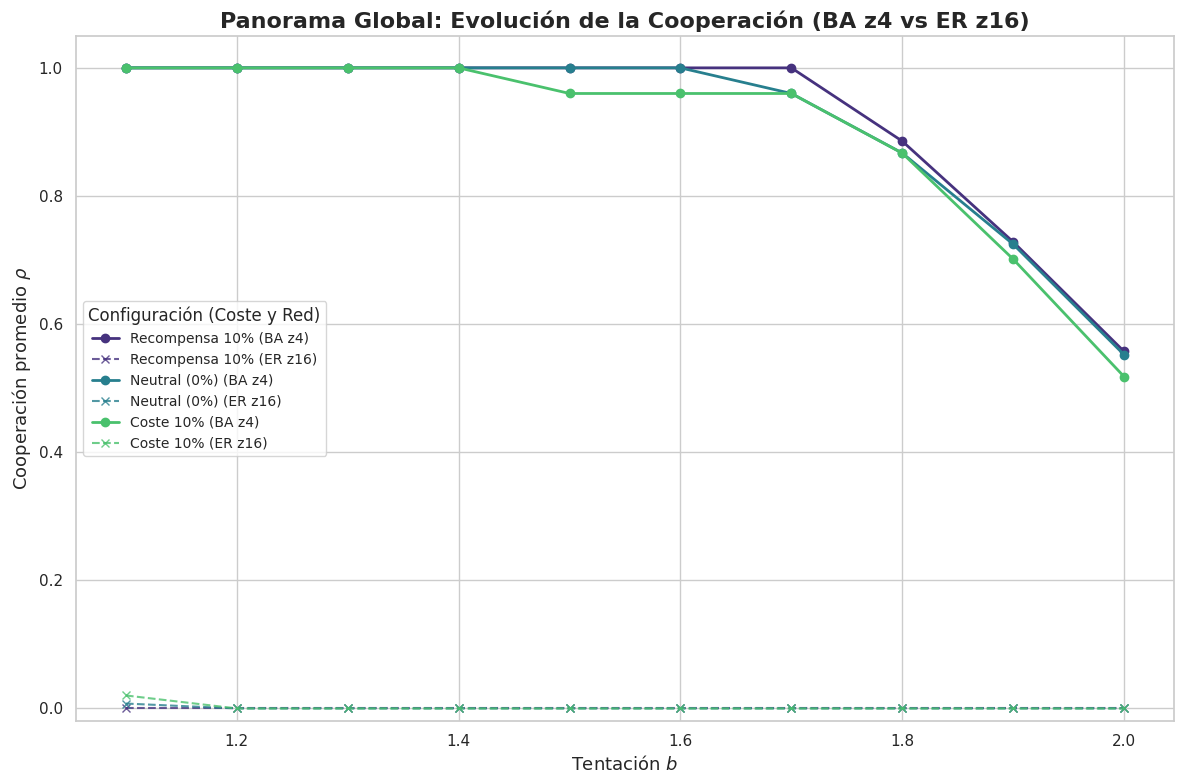

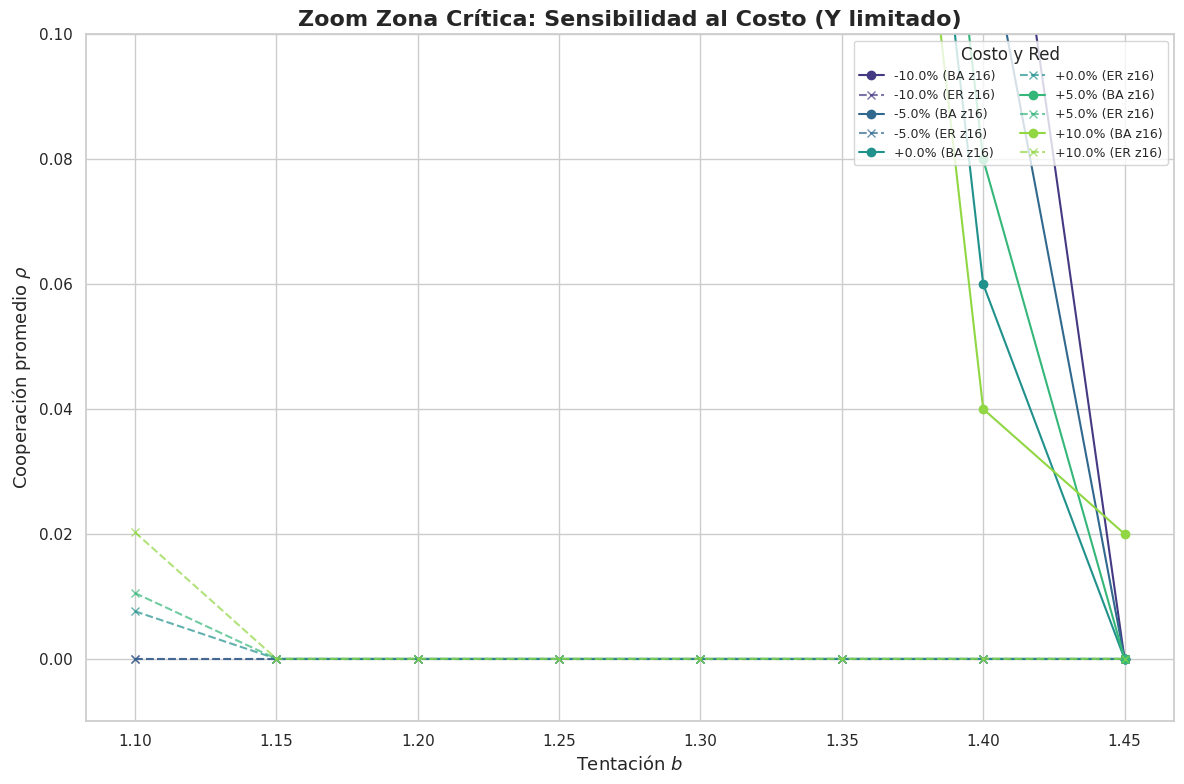

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Cargar archivos
v6 = pd.read_csv("/kaggle/input/phase2/V6.csv")
v7 = pd.read_csv("/kaggle/input/phase2/V7zoom.csv")

# Costos seleccionados para el panorama global
selected_costs = [-0.1, 0.0, 0.1]

# 1. Panorama Global (V6)
plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis")
color_map = {
    -0.1: palette[0],
    0.0: palette[2],
    0.1: palette[4]
}

for cp in selected_costs:
    label_prefix = f"Recompensa {abs(cp)*100:.0f}%" if cp < 0 else (f"Coste {cp*100:.0f}%" if cp > 0 else "Neutral (0%)")
    
    # BA z4
    subset_ba = v6[(v6["Topo"] == "BA") & (v6["Z"] == 4) & (v6["Cost_Pct"] == cp)].sort_values("b")
    if not subset_ba.empty:
        plt.plot(subset_ba["b"], subset_ba["C_mean"], marker='o', linestyle='-', 
                 label=f"{label_prefix} (BA z4)", color=color_map[cp], linewidth=2)
    
    # ER z16
    subset_er = v6[(v6["Topo"] == "ER") & (v6["Z"] == 16) & (v6["Cost_Pct"] == cp)].sort_values("b")
    if not subset_er.empty:
        plt.plot(subset_er["b"], subset_er["C_mean"], marker='x', linestyle='--', 
                 label=f"{label_prefix} (ER z16)", color=color_map[cp], linewidth=1.5, alpha=0.8)

plt.title("Panorama Global: Evolución de la Cooperación (BA z4 vs ER z16)", fontsize=16, fontweight='bold')
plt.xlabel("Tentación $b$", fontsize=13)
plt.ylabel("Cooperación promedio $\\rho$", fontsize=13)
plt.legend(title="Configuración (Coste y Red)", fontsize=10, loc='best', ncol=1)
plt.ylim(-0.02, 1.05)
plt.tight_layout()
plt.savefig("V6_Panorama_Global_ES.png", dpi=300)

# 2. Zoom Crítico (V7zoom) - Limitando el eje Y
# Nota: V7zoom contiene BA z16 y ER z16 segun inspecciones previas, pero verificaremos si hay z4.
# Si no hay z4 en V7zoom, usaremos lo disponible pero con el zoom solicitado.

plt.figure(figsize=(12, 8))

# Vamos a graficar más costos en el zoom para ver la sensibilidad
zoom_costs = [-0.1, -0.05, 0.0, 0.05, 0.1]
palette_zoom = sns.color_palette("viridis", len(zoom_costs))

for i, cp in enumerate(zoom_costs):
    label_prefix = f"{cp*100:+.1f}%"
    
    # Intentar BA z4 o BA z16
    subset_ba = v7[(v7["Topo"] == "BA") & (v7["Cost_Pct"] == cp)].sort_values("b")
    if not subset_ba.empty:
        z_ba = subset_ba['Z'].iloc[0]
        plt.plot(subset_ba["b"], subset_ba["C_mean"], marker='o', linestyle='-', 
                 label=f"{label_prefix} (BA z{z_ba})", color=palette_zoom[i])
    
    # ER z16
    subset_er = v7[(v7["Topo"] == "ER") & (v7["Z"] == 16) & (v7["Cost_Pct"] == cp)].sort_values("b")
    if not subset_er.empty:
        plt.plot(subset_er["b"], subset_er["C_mean"], marker='x', linestyle='--', 
                 label=f"{label_prefix} (ER z16)", color=palette_zoom[i], alpha=0.7)

plt.ylim(-0.01, 0.1) # Limitamos Y para ver mejor la separación de las curvas que caen

plt.title("Zoom Zona Crítica: Sensibilidad al Costo (Y limitado)", fontsize=16, fontweight='bold')
plt.xlabel("Tentación $b$", fontsize=13)
plt.ylabel("Cooperación promedio $\\rho$", fontsize=13)
plt.legend(title="Costo y Red", fontsize=9, loc='upper right', ncol=2)
plt.tight_layout()
plt.savefig("V7_Zoom_Critico_Limitado_ES.png", dpi=300)

print("Gráficos generados.")

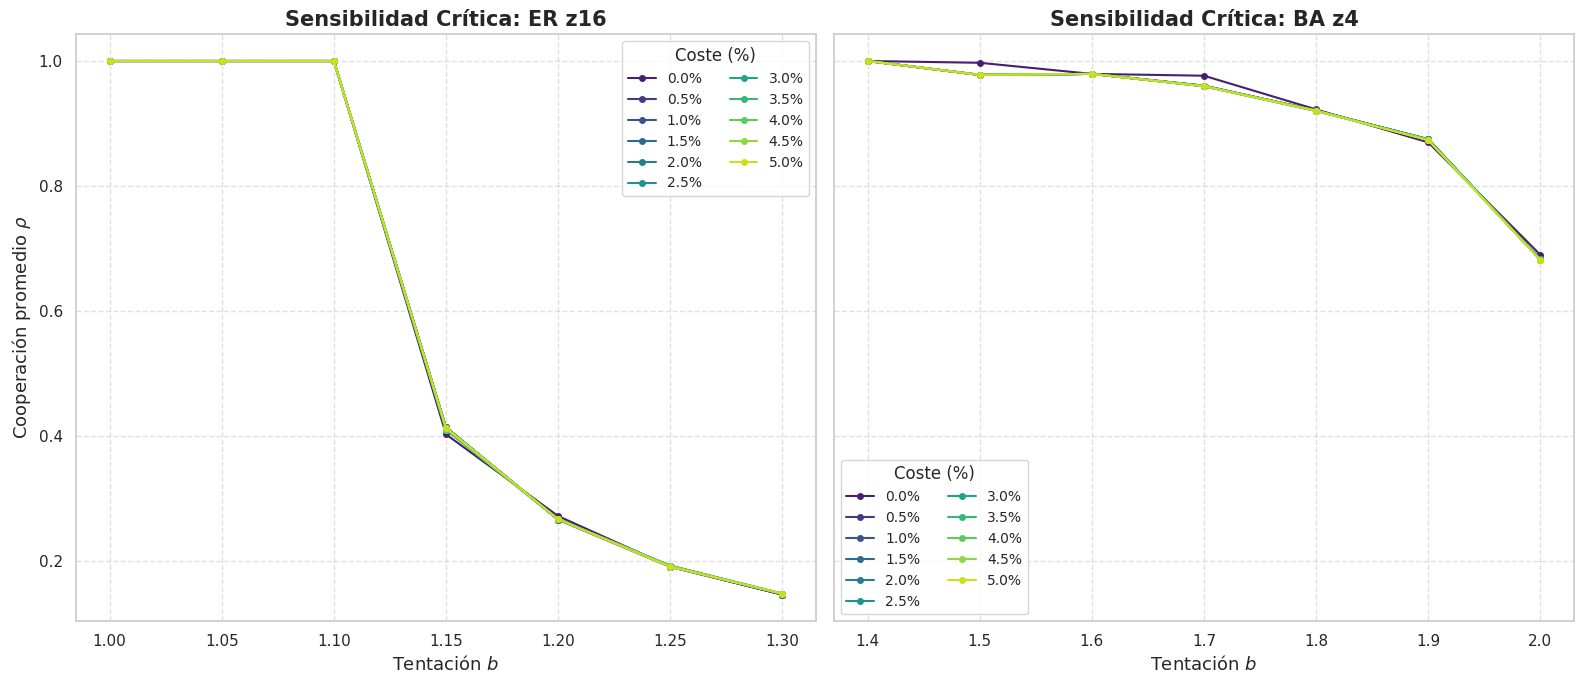

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Cargamos los datos reales del archivo V11.csv
df_v11 = pd.read_csv("/kaggle/input/phase2/V11.csv")

fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# Definimos las topologías y sus etiquetas específicas (BA z4 y ER z16)
topos = [("ER", "ER z16"), ("BA", "BA z4")]

for i, (topo_key, label_display) in enumerate(topos):
    ax = axes[i]
    subset = df_v11[df_v11["Topo"] == topo_key]
    costs = sorted(subset["Cost_Pct"].unique())
    
    # Usamos el mapa de colores 'viridis'
    colors = sns.color_palette("viridis",len(costs))
    for j, cp in enumerate(costs):
        data = subset[subset["Cost_Pct"] == cp].sort_values("b")
        # Graficamos la cooperación promedio (C_mean)
        ax.plot(data["b"], data["C_mean"], 
                label=f"{cp*100:.1f}%", 
                color=colors[j], 
                marker=".", 
                markersize=8)

    ax.set_title(f"Sensibilidad Crítica: {label_display}", fontsize=15, fontweight='bold')
    ax.set_xlabel("Tentación $b$", fontsize=13)
    if i == 0:
        ax.set_ylabel("Cooperación promedio $\\rho$", fontsize=13)
    
    ax.legend(title="Coste (%)", ncol=2, fontsize='small', loc='best')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("PARTIE2_Sensibilidad_Critica_Viridis.png", dpi=300)
plt.show()

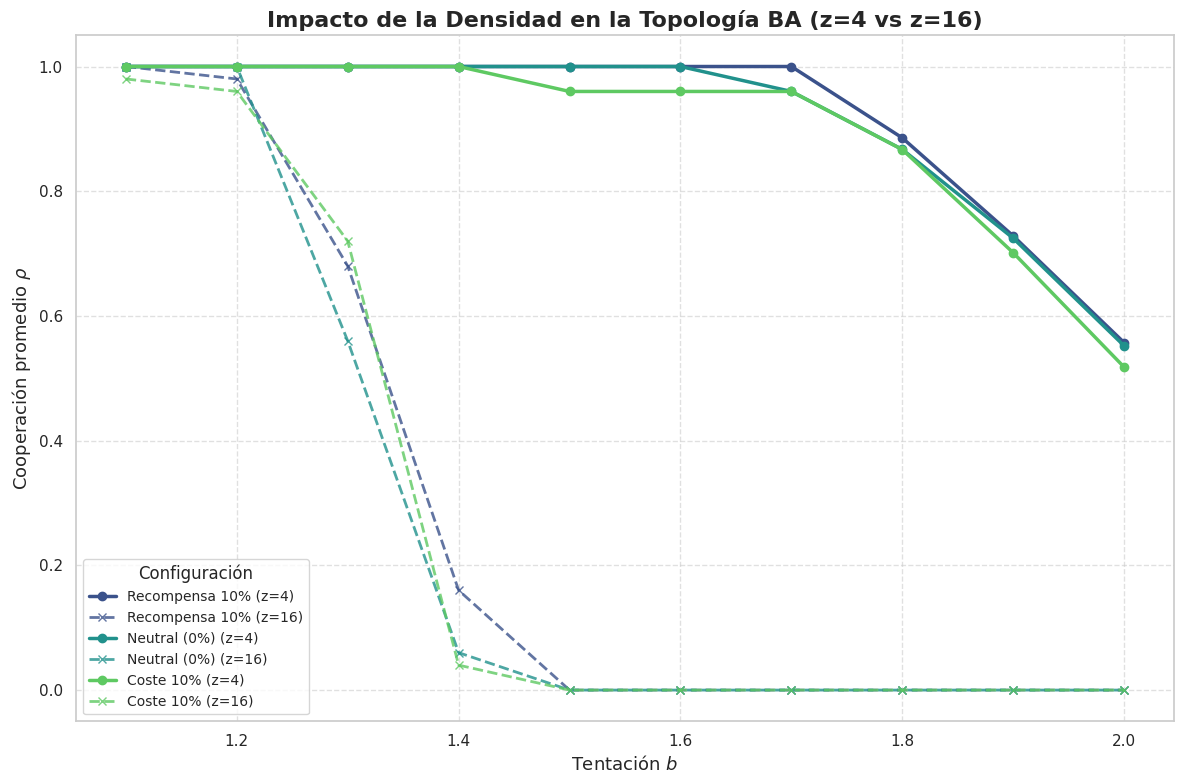

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.color_palette("viridis",5)
plt.rcParams.update({'font.size': 12})

# Cargar los datos
df = pd.read_csv("/kaggle/input/phase2/V6_2.0.csv")

# Filtrar solo para la topología BA
ba_df = df[df["Topo"] == "BA"]

# Seleccionar costos representativos
selected_costs = [-0.1, 0.0, 0.1]
palette = sns.color_palette("viridis", len(selected_costs))

plt.figure(figsize=(12, 8))

for i, cp in enumerate(selected_costs):
    # Etiqueta del costo
    if cp < 0:
        cost_label = f"Recompensa {abs(cp)*100:.0f}%"
    elif cp > 0:
        cost_label = f"Coste {cp*100:.0f}%"
    else:
        cost_label = "Neutral (0%)"
    
    # Datos para z=4
    data_z4 = ba_df[(ba_df["Z"] == 4) & (ba_df["Cost_Pct"] == cp)].sort_values("b")
    if not data_z4.empty:
        plt.plot(data_z4["b"], data_z4["C_mean"], marker='o', linestyle='-', 
                 label=f"{cost_label} (z=4)", color=palette[i], linewidth=2.5)
    
    # Datos para z=16
    data_z16 = ba_df[(ba_df["Z"] == 16) & (ba_df["Cost_Pct"] == cp)].sort_values("b")
    if not data_z16.empty:
        plt.plot(data_z16["b"], data_z16["C_mean"], marker='x', linestyle='--', 
                 label=f"{cost_label} (z=16)", color=palette[i], linewidth=2, alpha=0.8)

plt.title("Impacto de la Densidad en la Topología BA (z=4 vs z=16)", fontsize=16, fontweight='bold')
plt.xlabel("Tentación $b$", fontsize=13)
plt.ylabel("Cooperación promedio $\\rho$", fontsize=13)
plt.ylim(-0.05, 1.05)
plt.legend(title="Configuración", fontsize=10, loc='best', ncol=1)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("BA_Z4_vs_Z16_Impacto.png", dpi=300)
plt.show()

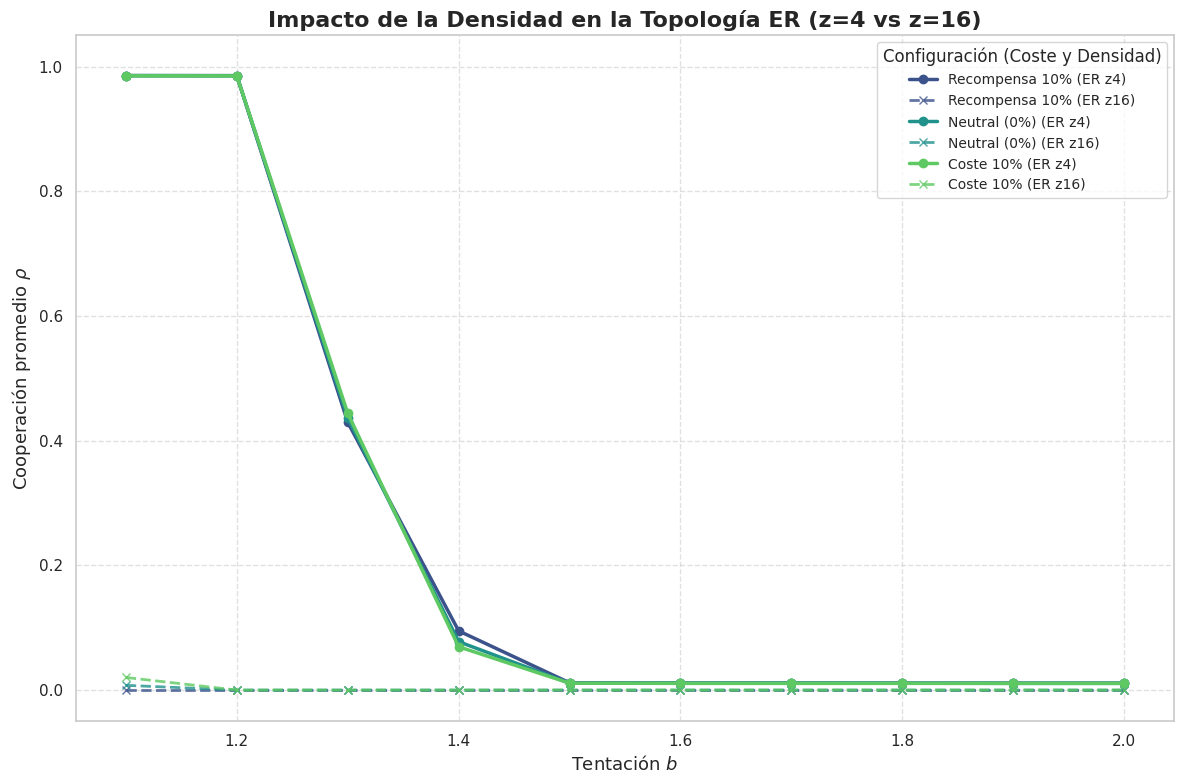

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Cargar los datos
df_v14 = pd.read_csv("/kaggle/input/phase2/V14_2.0.csv") # Contiene ER z4
df_v6 = pd.read_csv("/kaggle/input/phase2/V6_2.0.csv")   # Contiene ER z16

# Filtrar para la topología ER
er_z4 = df_v14[(df_v14["Topo"] == "ER") & (df_v14["Z"] == 4)]
er_z16 = df_v6[(df_v6["Topo"] == "ER") & (df_v6["Z"] == 16)]

# Seleccionar costos representativos
selected_costs = [-0.1, 0.0, 0.1]
palette = sns.color_palette("viridis", len(selected_costs))

plt.figure(figsize=(12, 8))

for i, cp in enumerate(selected_costs):
    # Etiqueta del costo
    if cp < 0:
        cost_label = f"Recompensa {abs(cp)*100:.0f}%"
    elif cp > 0:
        cost_label = f"Coste {cp*100:.0f}%"
    else:
        cost_label = "Neutral (0%)"
    
    # Datos para ER z=4 (Línea continua con círculos)
    data_z4 = er_z4[er_z4["Cost_Pct"] == cp].sort_values("b")
    if not data_z4.empty:
        plt.plot(data_z4["b"], data_z4["C_mean"], marker='o', linestyle='-', 
                 label=f"{cost_label} (ER z4)", color=palette[i], linewidth=2.5)
    
    # Datos para ER z=16 (Línea discontinua con cruces)
    data_z16 = er_z16[er_z16["Cost_Pct"] == cp].sort_values("b")
    if not data_z16.empty:
        plt.plot(data_z16["b"], data_z16["C_mean"], marker='x', linestyle='--', 
                 label=f"{cost_label} (ER z16)", color=palette[i], linewidth=2, alpha=0.8)

plt.title("Impacto de la Densidad en la Topología ER (z=4 vs z=16)", fontsize=16, fontweight='bold')
plt.xlabel("Tentación $b$", fontsize=13)
plt.ylabel("Cooperación promedio $\\rho$", fontsize=13)
plt.ylim(-0.05, 1.05)
plt.legend(title="Configuración (Coste y Densidad)", fontsize=10, loc='best', ncol=1)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("ER_Z4_vs_Z16_Impacto.png", dpi=300)

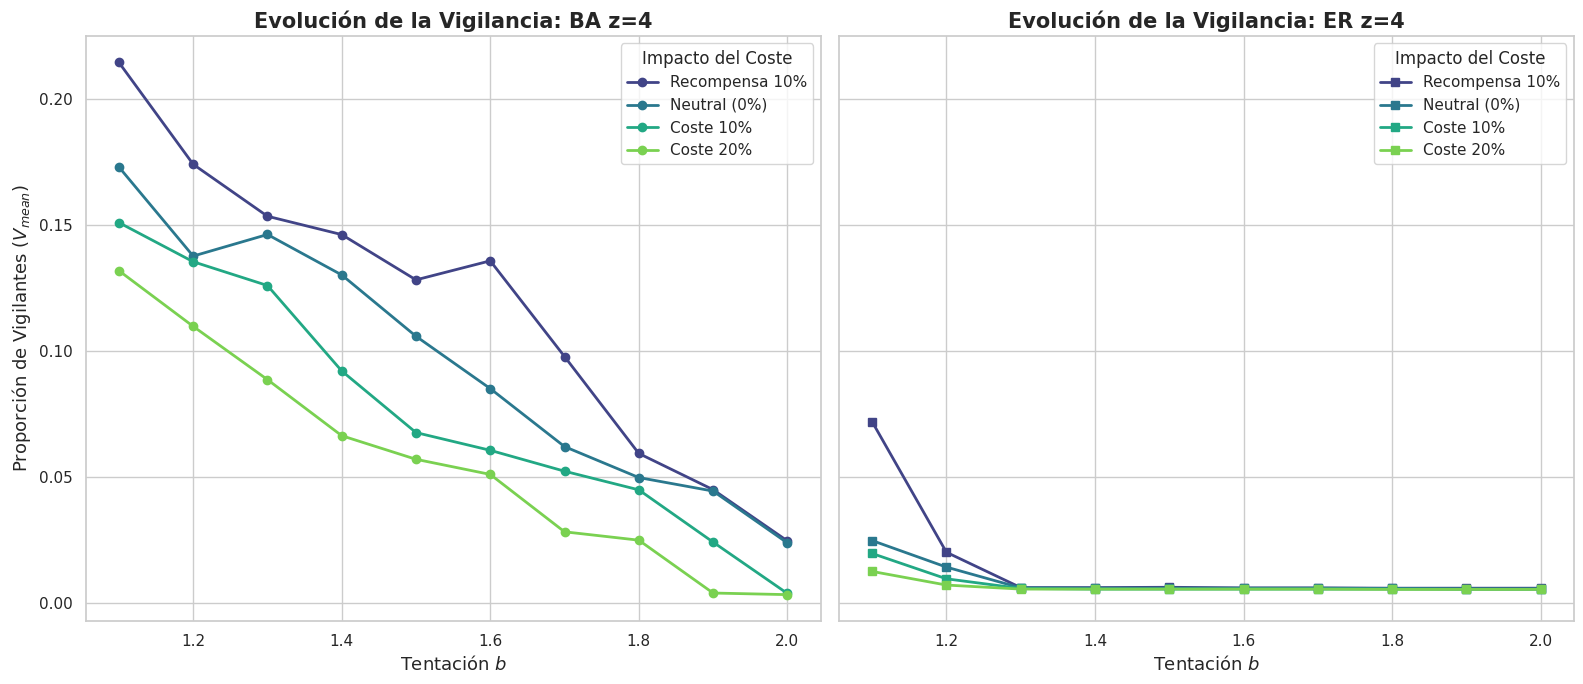

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Cargar los datos
v6 = pd.read_csv("/kaggle/input/phase2/V6_2.0.csv")
v14 = pd.read_csv("/kaggle/input/phase2/V14_2.0.csv")

# Seleccionar costos representativos
selected_costs = [-0.1, 0.0, 0.1, 0.2]
palette = sns.color_palette("viridis", len(selected_costs))

fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

# --- Gráfico 1: Evolución de la Vigilancia en BA (z=4) ---
ax1 = axes[0]
ba_subset = v6[(v6["Topo"] == "BA") & (v6["Z"] == 4)]

for i, cp in enumerate(selected_costs):
    data = ba_subset[ba_subset["Cost_Pct"] == cp].sort_values("b")
    if not data.empty:
        label = f"Recompensa {abs(cp)*100:.0f}%" if cp < 0 else (f"Coste {cp*100:.0f}%" if cp > 0 else "Neutral (0%)")
        ax1.plot(data["b"], data["V_mean"], marker='o', label=label, color=palette[i], linewidth=2)

ax1.set_title("Evolución de la Vigilancia: BA z=4", fontsize=15, fontweight='bold')
ax1.set_xlabel("Tentación $b$", fontsize=13)
ax1.set_ylabel("Proporción de Vigilantes ($V_{mean}$)", fontsize=13)
ax1.legend(title="Impacto del Coste")

# --- Gráfico 2: Evolución de la Vigilancia en ER (z=16) ---
ax2 = axes[1]
er_subset = v14[(v14["Topo"] == "ER") & (v14["Z"] == 4)]

for i, cp in enumerate(selected_costs):
    data = er_subset[er_subset["Cost_Pct"] == cp].sort_values("b")
    if not data.empty:
        label = f"Recompensa {abs(cp)*100:.0f}%" if cp < 0 else (f"Coste {cp*100:.0f}%" if cp > 0 else "Neutral (0%)")
        ax2.plot(data["b"], data["V_mean"], marker='s', label=label, color=palette[i], linewidth=2)

ax2.set_title("Evolución de la Vigilancia: ER z=4", fontsize=15, fontweight='bold')
ax2.set_xlabel("Tentación $b$", fontsize=13)
# ax2.set_ylabel("Proporción de Vigilantes ($V_{mean}$)", fontsize=13)
ax2.legend(title="Impacto del Coste")

plt.tight_layout()
plt.savefig("Evolucion_Vigilancia_Costes.png", dpi=300)
plt.show()


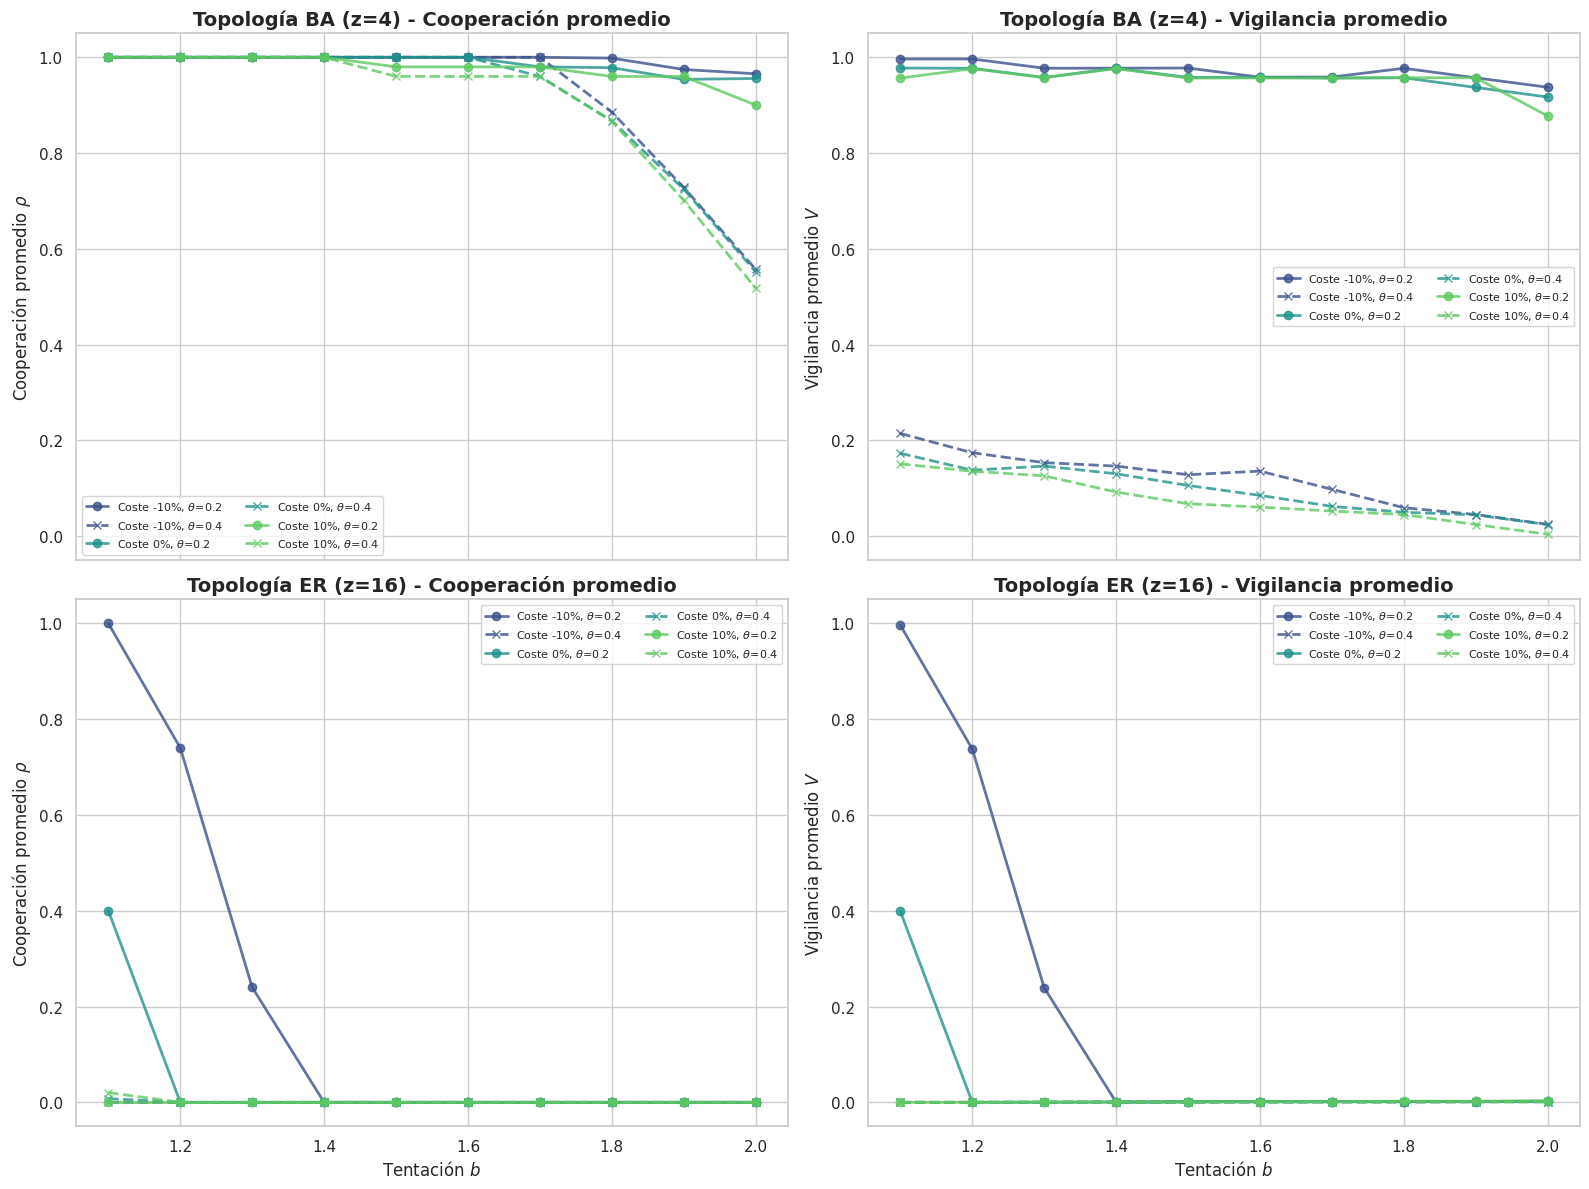

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Carga de archivos
df04 = pd.read_csv("/kaggle/input/phase2/V6.csv")
df02 = pd.read_csv("/kaggle/input/phase2/theta0.2.csv")

# Añadir columna de Theta para distinguir
df04['Theta'] = 0.4
df02['Theta'] = 0.2

# Combinar datasets
df_comp = pd.concat([df04, df02], ignore_index=True)

# Seleccionar costos representativos
selected_costs = [-0.1, 0.0, 0.1]
df_comp = df_comp[df_comp['Cost_Pct'].isin(selected_costs)]

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 10})

# Crear figura 2x2 (Filas: Topo, Columnas: Variable (Coop, Vigilance))
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex='col')

topos = [("BA", 4), ("ER", 16)]
variables = [("C_mean", "Cooperación promedio $\\rho$"), ("V_mean", "Vigilancia promedio $V$")]

# Crear paleta viridis para los costos
unique_costs = sorted(selected_costs)
viridis_palette = sns.color_palette("viridis", len(unique_costs))
cost_colors = {cost: viridis_palette[i] for i, cost in enumerate(unique_costs)}

styles = { 0.2: '-', 0.4: '--' }
markers = { 0.2: 'o', 0.4: 'x' }

for i, (topo, z) in enumerate(topos):
    for j, (var, var_label) in enumerate(variables):
        ax = axes[i, j]
        subset_topo = df_comp[(df_comp['Topo'] == topo) & (df_comp['Z'] == z)]
        
        for cost in unique_costs:
            for theta in [0.2, 0.4]:
                data = subset_topo[(subset_topo['Cost_Pct'] == cost) & (subset_topo['Theta'] == theta)].sort_values('b')
                if not data.empty:
                    label = f"Coste {cost*100:.0f}%, $\\theta$={theta}"
                    ax.plot(data['b'], data[var], 
                            label=label, 
                            color=cost_colors[cost], 
                            linestyle=styles[theta], 
                            marker=markers[theta], 
                            alpha=0.8,
                            linewidth=2)
        
        ax.set_title(f"Topología {topo} (z={z}) - {var_label.split('$')[0].strip()}", fontsize=14, fontweight='bold')
        ax.set_ylabel(var_label)
        if i == 1:
            ax.set_xlabel("Tentación $b$")
        ax.legend(fontsize=8, ncol=2)
        ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.savefig("comparacion_theta_02_04_viridis.png", dpi=300)

Grafico guardado como comparacion_L1_L4_viridis_theta0.4.png


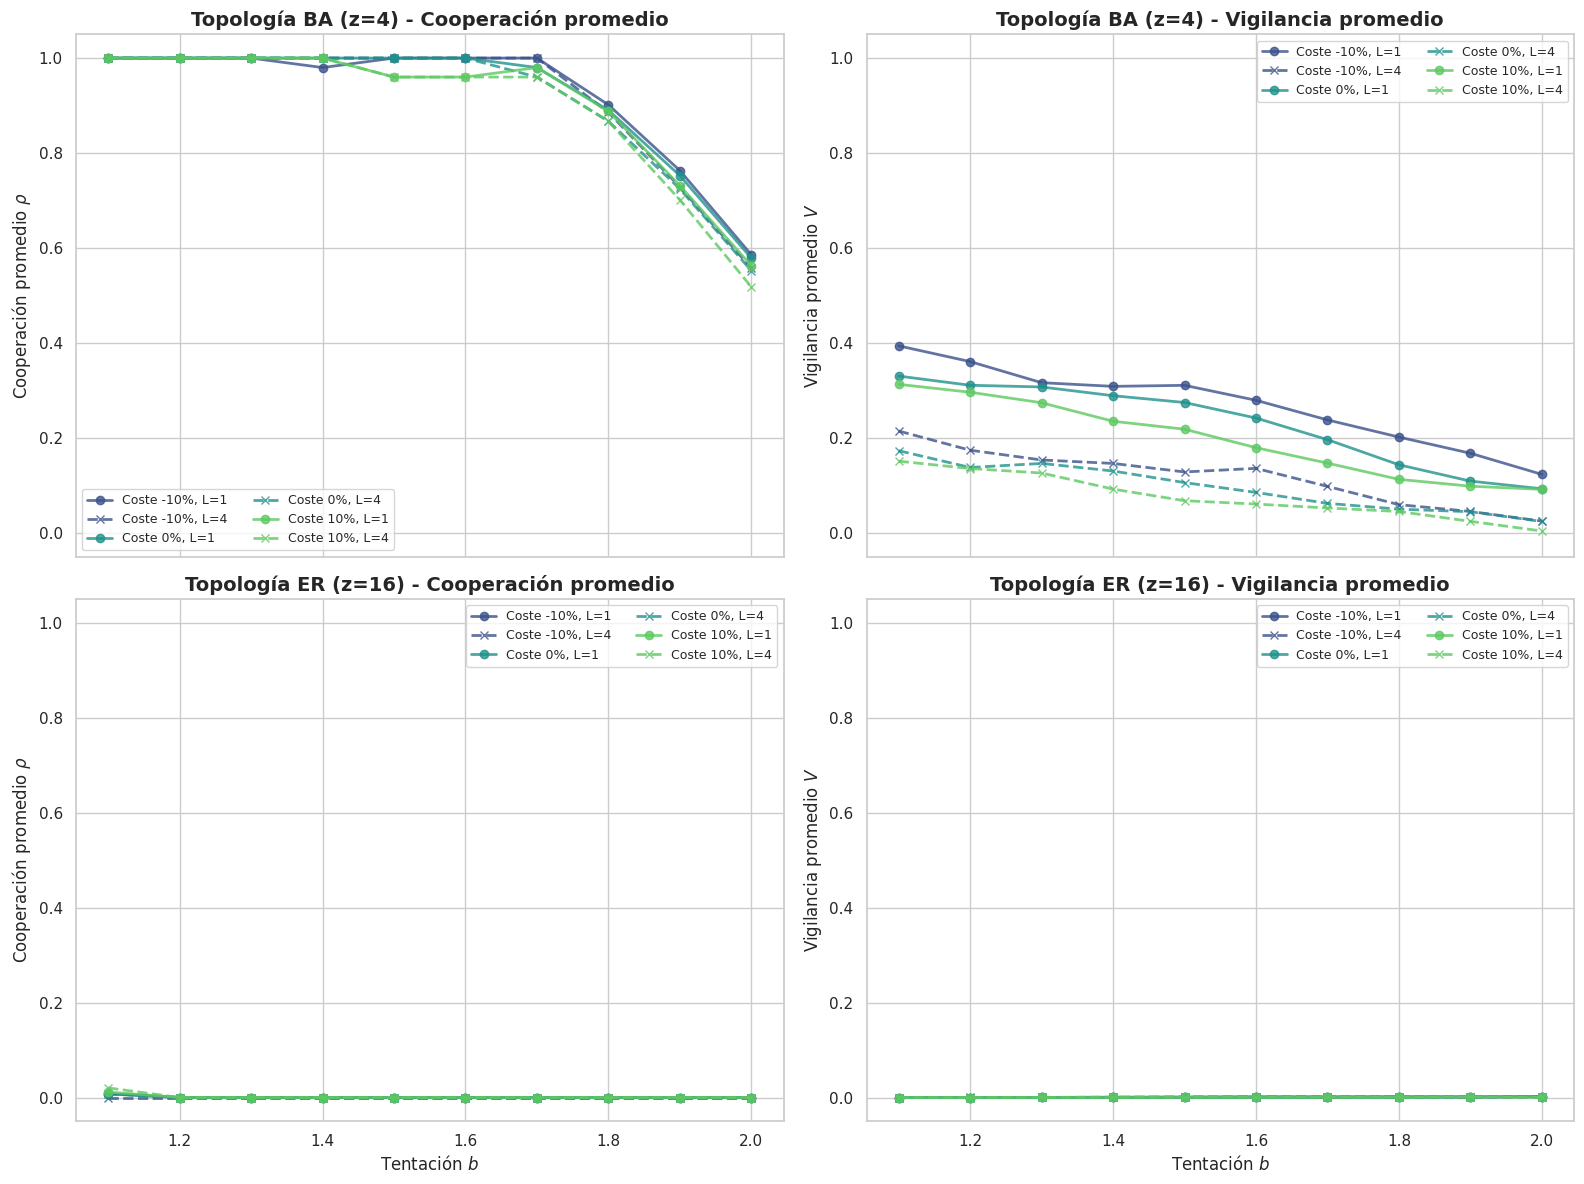

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Carga de archivos
df_l1 = pd.read_csv("/kaggle/input/phase2/Comparaison_final_L1.csv")
df_l4 = pd.read_csv("/kaggle/input/phase2/V6.csv")

# Añadir columna de L para distinguir
df_l1['L'] = 1
df_l4['L'] = 4

# Combinar datasets
df_comp = pd.concat([df_l1, df_l4], ignore_index=True)

# Seleccionar costos representativos
selected_costs = [-0.1, 0.0, 0.1]
df_comp = df_comp[df_comp['Cost_Pct'].isin(selected_costs)]

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Crear figura 2x2 (Filas: Topo, Columnas: Variable (Coop, Vigilance))
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex='col')

topos = [("BA", 4), ("ER", 16)]
variables = [("C_mean", "Cooperación promedio $\\rho$"), ("V_mean", "Vigilancia promedio $V$")]

# Crear paleta viridis para los costos
unique_costs = sorted(selected_costs)
viridis_palette = sns.color_palette("viridis", len(unique_costs))
cost_colors = {cost: viridis_palette[i] for i, cost in enumerate(unique_costs)}

# Estilos para L
styles = { 1: '-', 4: '--' }
markers = { 1: 'o', 4: 'x' }

for i, (topo, z) in enumerate(topos):
    for j, (var, var_label) in enumerate(variables):
        ax = axes[i, j]
        subset_topo = df_comp[(df_comp['Topo'] == topo) & (df_comp['Z'] == z)]
        
        for cost in unique_costs:
            for L_val in [1, 4]:
                data = subset_topo[(subset_topo['Cost_Pct'] == cost) & (subset_topo['L'] == L_val)].sort_values('b')
                if not data.empty:
                    label = f"Coste {cost*100:.0f}%, L={L_val}"
                    ax.plot(data['b'], data[var], 
                            label=label, 
                            color=cost_colors[cost], 
                            linestyle=styles[L_val], 
                            marker=markers[L_val], 
                            alpha=0.8,
                            linewidth=2)
        
        ax.set_title(f"Topología {topo} (z={z}) - {var_label.split('$')[0].strip()}", fontsize=14, fontweight='bold')
        ax.set_ylabel(var_label)
        if i == 1:
            ax.set_xlabel("Tentación $b$")
        ax.legend(fontsize=9, ncol=2)
        ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
output_filename = "comparacion_L1_L4_viridis_theta0.4.png"
plt.savefig(output_filename, dpi=300)
print(f"Grafico guardado como {output_filename}")

Grafico guardado como comparacion_L1_L4_viridis_theta0.2.png


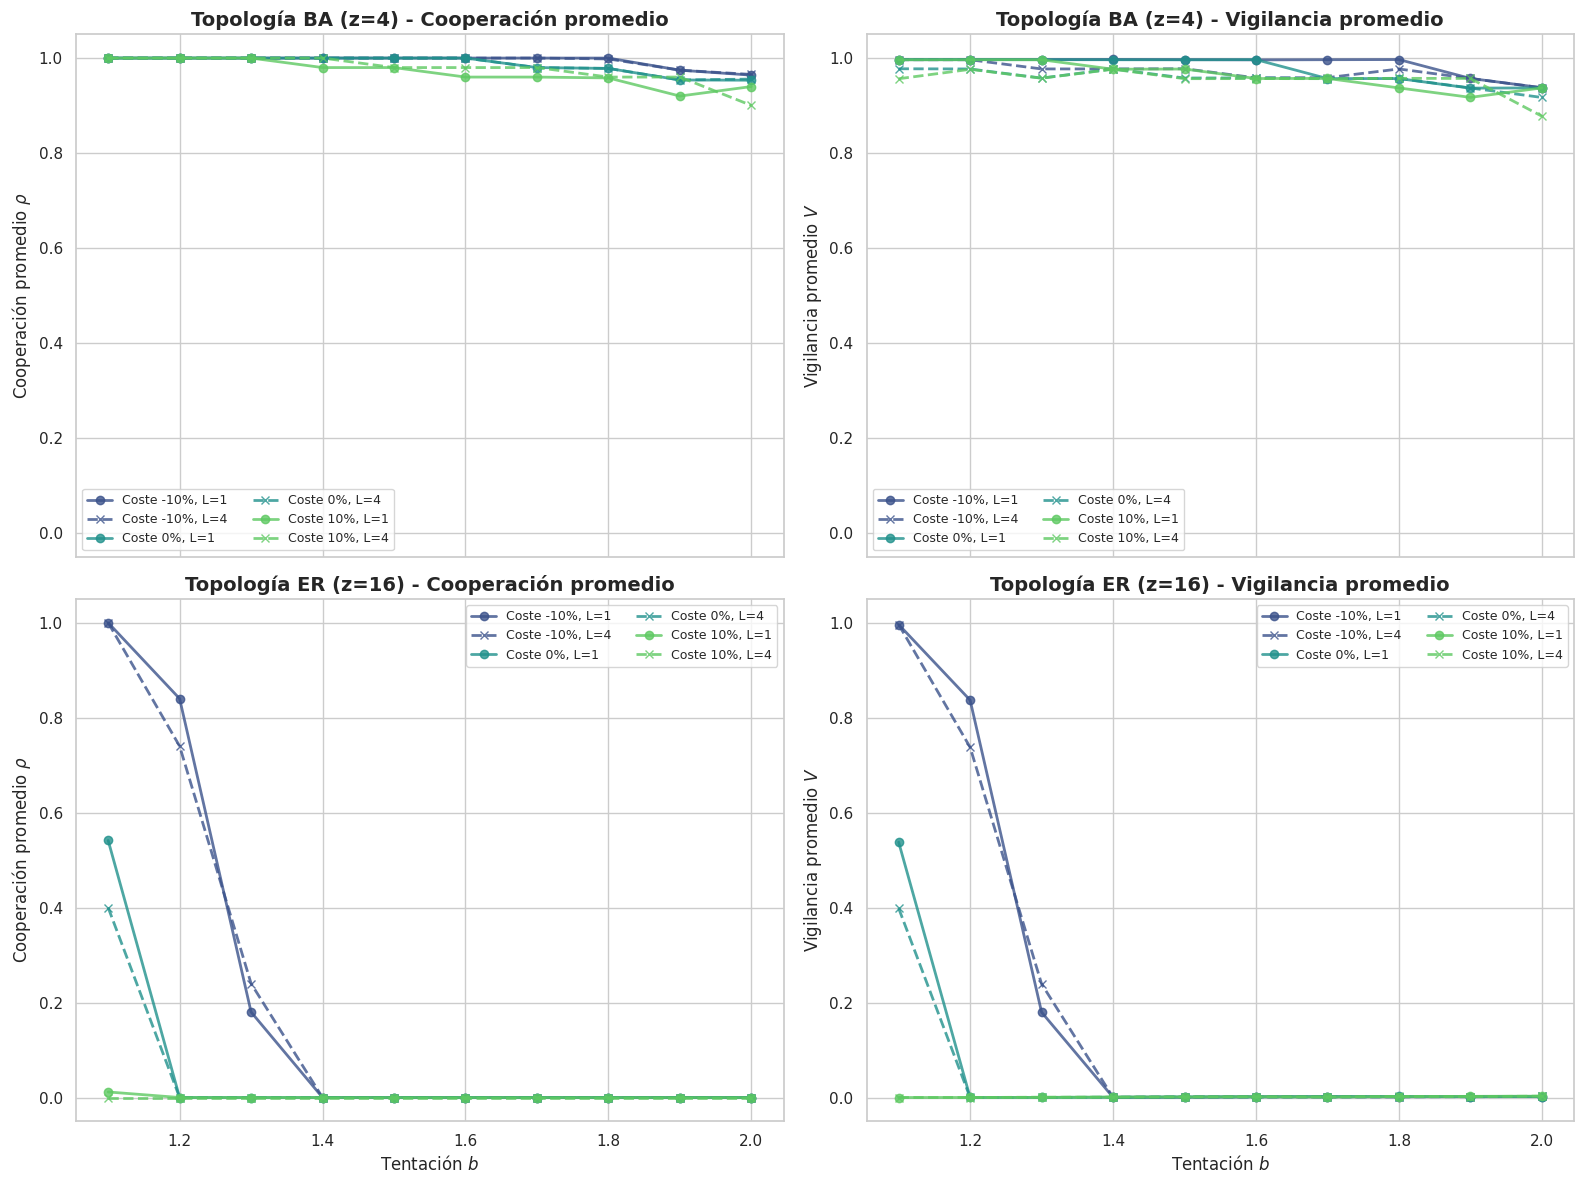

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Carga de archivos
df_l1 = pd.read_csv("/kaggle/input/phase2/Comparaison_final_L1_0.2.csv")
df_l4 = pd.read_csv("/kaggle/input/phase2/theta0.2.csv")

# Añadir columna de L para distinguir
df_l1['L'] = 1
df_l4['L'] = 4

# Combinar datasets
df_comp = pd.concat([df_l1, df_l4], ignore_index=True)

# Seleccionar costos representativos
selected_costs = [-0.1, 0.0, 0.1]
df_comp = df_comp[df_comp['Cost_Pct'].isin(selected_costs)]

# Configuración de estilo
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Crear figura 2x2 (Filas: Topo, Columnas: Variable (Coop, Vigilance))
fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex='col')

topos = [("BA", 4), ("ER", 16)]
variables = [("C_mean", "Cooperación promedio $\\rho$"), ("V_mean", "Vigilancia promedio $V$")]

# Crear paleta viridis para los costos
unique_costs = sorted(selected_costs)
viridis_palette = sns.color_palette("viridis", len(unique_costs))
cost_colors = {cost: viridis_palette[i] for i, cost in enumerate(unique_costs)}

# Estilos para L
styles = { 1: '-', 4: '--' }
markers = { 1: 'o', 4: 'x' }

for i, (topo, z) in enumerate(topos):
    for j, (var, var_label) in enumerate(variables):
        ax = axes[i, j]
        subset_topo = df_comp[(df_comp['Topo'] == topo) & (df_comp['Z'] == z)]
        
        for cost in unique_costs:
            for L_val in [1, 4]:
                data = subset_topo[(subset_topo['Cost_Pct'] == cost) & (subset_topo['L'] == L_val)].sort_values('b')
                if not data.empty:
                    label = f"Coste {cost*100:.0f}%, L={L_val}"
                    ax.plot(data['b'], data[var], 
                            label=label, 
                            color=cost_colors[cost], 
                            linestyle=styles[L_val], 
                            marker=markers[L_val], 
                            alpha=0.8,
                            linewidth=2)
        
        ax.set_title(f"Topología {topo} (z={z}) - {var_label.split('$')[0].strip()}", fontsize=14, fontweight='bold')
        ax.set_ylabel(var_label)
        if i == 1:
            ax.set_xlabel("Tentación $b$")
        ax.legend(fontsize=9, ncol=2)
        ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
output_filename = "comparacion_L1_L4_viridis_theta0.2.png"
plt.savefig(output_filename, dpi=300)
print(f"Grafico guardado como {output_filename}")